In [ ]:
# default_exp timeseries

# timeseries

> Módulo com implementação de algoritmos para detecção de **anomalias em series temporais**.

In [ ]:
#export
import numpy as np
import pandas as pd

from pyanomaly.stats import MAD, Tukey
from pyanomaly.utils import plot_anomalies

In [ ]:
#export
def factory_atype(atype='mad'):
    if atype == 'mad':
        return MAD()
    elif atype == 'tukey':
        return Tukey
    else:
        raise ValueError('Algoritmo de detecção de anomalia não implementado - \"{}\"'.format(atype))

## Moving Average

In [ ]:
#export
def moving_average(ts, window=12, atype='mad'):
    ''' 
    Detecção de anomalias com base no Moving Average da serie tempora(ts).
    ts = numpy array      - serie temporal
    window_size = [2..n]  - Tamanho da janela
    atype = ['mad', 'tukey'] - algoritmo para detecção de anomalias'''
    ts_ma = pd.Series(ts).rolling(window).mean()
    m = factory_atype(atype)
    m.fit(ts_ma)
    return m.predict(ts_ma)

In [ ]:
#export
def moving_average_score(ts, window=12,  atype='mad'):
    '''
    Detecção de anomalias com base no Moving Average da serie tempora(ts).
    ts = numpy array      - serie temporal
    window_size = [2..n]  - Tamanho da janela
    atype = ['mad', 'tukey'] - algoritmo para detecção de anomalias'''
    ts_ma = pd.Series(ts).rolling(window).mean()
    m = factory_atype(atype)
    m.fit(ts_ma)
    return m.decision_function(ts_ma)

## Twitter

O algoritmo popularizado pelo Twitter é um conjunto como o **Seasonal Hybrid ESD (S-H-ESD)**  que funciona em cima do **Generalized ESD test** para detecção de anomalias. S-H-ESD pode ser utilizado tanto para detecção local ou global de anomalias. O método envolvi decompor a serie temporal e utilizar métodos robustos para detecção de anomalias(MAD).

Já existe a implementação fornecida pelo **Twitter** na linguagem **R**, a seguir temos a implementação do algoritmo feita em Python.

Artigo: https://arxiv.org/pdf/1704.07706.pdf

Obs: Implementacao esta atualmente utilizando o MAD ao inves do ESD **##TODO**

In [ ]:
#export
from statsmodels.tsa.seasonal import STL

def twitter(x, m=3.0, period=None, seasonal=45, only_low_values=False):
    ''' 
        Retorna os index dos valores que são anomalias
        input precisa ser um Serie com DateTimeIndex'''
    # filtrando o componente seasonal
    if period is not None:
        stl = STL(x, period=period, seasonal=seasonal)
    else:
        stl = STL(x, seasonal=seasonal)
    
    res = stl.fit()
    # calculamos o residuo
    residuo = x - np.nanmedian(x) - res.seasonal
    # Procuramos outliers com MAD
    mad = MAD(only_low_values=only_low_values)
    mad.fit(residuo)
    index = mad.predict(residuo, m=m).index
    return x.loc[index]

In [ ]:
#export
from statsmodels.tsa.seasonal import STL

def twitter_score(x, m=3.0, period=None, seasonal=45):
    ''' 
        Retorna os index dos valores que são anomalias
        input precisa ser um Serie com index temporal'''
    # filtrando o componente seasonal
    if period is not None:
        stl = STL(x, period=period, seasonal=seasonal)
    else:
        stl = STL(x, seasonal=seasonal)
    res = stl.fit()
    # calculamos o residuo
    residuo = x - np.nanmedian(x) - res.seasonal
    # Procuramos outliers com MAD
    mad = MAD()
    mad.fit(residuo, m=m)
    return mad.decision_function(residuo)

# Teste

In [ ]:
df = pd.read_csv('./dados/rec-center-hourly.csv', parse_dates=[0])
df.set_index('datetime', inplace=True)
df.head()

,kw_energy_consumption
datetime,
2010-07-02 00:00:00,21.2
2010-07-02 01:00:00,16.4
2010-07-02 02:00:00,4.7
2010-07-02 03:00:00,4.7
2010-07-02 04:00:00,4.6


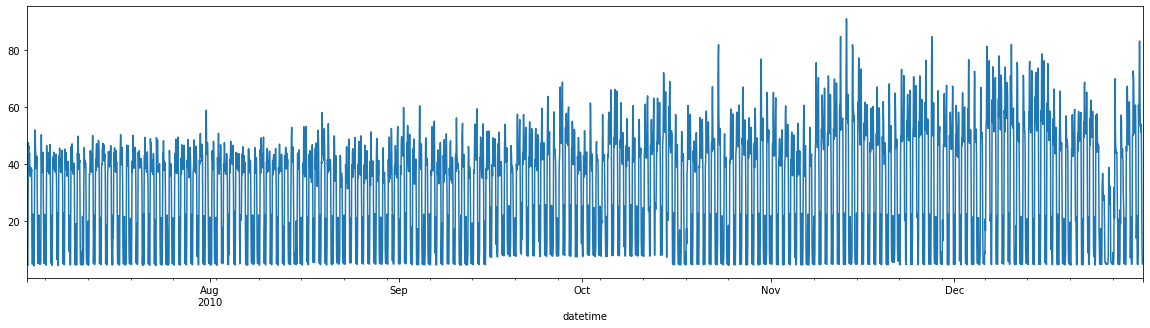

In [ ]:
ts = df['kw_energy_consumption']
ts.plot(figsize=(20, 5));

In [ ]:
24*7 # Week seasonality 24*7

168

In [ ]:
anomalies = twitter(df['kw_energy_consumption'], period=168, only_low_values=True)
anomalies.head(), len(anomalies)

(datetime
 2010-07-21 01:00:00     4.6
 2010-09-03 05:00:00    12.3
 2010-09-04 06:00:00     9.6
 2010-09-10 05:00:00    14.4
 2010-09-13 05:00:00     9.9
 Name: kw_energy_consumption, dtype: float64,
 40)

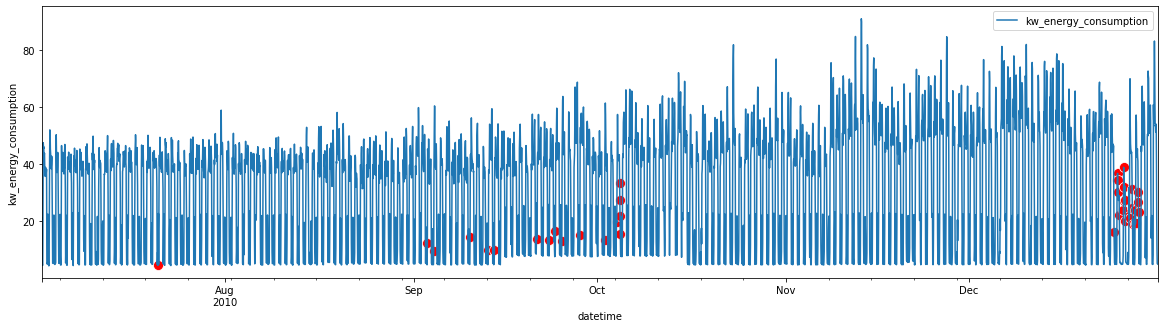

In [ ]:
plot_anomalies(ts, anomalies, s=100);